## Analyse IRM_Marche SMA
--
Parcellation en 444 regions (BASC Atlas) --> SEULEMENT SMA

Classification : SVM Linéaire

Sujets sains (66)

Classification Marche Confortable VS Rest
--
Cross validée par run (9)

In [1]:
import numpy as np
from scipy.stats import binom_test
from sklearn.pipeline import Pipeline   
from sklearn.svm import SVC
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from nilearn.datasets import load_mni152_brain_mask
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score
from sklearn.externals.joblib import Memory
%matplotlib inline
from nilearn.plotting import plot_stat_map
import sys
sys.path[0]='Z:/GitHub/gsp-learn/'
from gsplearn.GSPTransform import GraphTransformer
from gsplearn.GSPPlot import plot_selectedregions
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
motor_label=np.fromfile('F:/IRM_Marche/masquesROI/reg_all_nooccipital_basc444asym.np','int')
#motor_label=np.arange(410,444)
fold='F:/IRM_marche/all_mni_imp_imag/'
smt='ss'       
names=('ap','as','bh','bi','boh','cmp','cas','cs','cb','gm','gn','gbn','mv',
       'ms','pm','pc','ph','pa','pv','pom','rdc','ti','vs',
       'an','bm','cc','ci','cjf','fb','fm','gmc','hnc','lm','mac',
       'marc','marm','om','pic','pr','qs','ris','sn','tj','va',
       'af','ba','be','br','ds','fj','gv','hc','hn',
       'lbc','lc','my','pj','pf','wl',#'dc','rs',#trop de mvt   
      # 'mc','lp','dm','ea',# gauchers + 'sam'/pas analysé
      # 'gem','gc',# Amb
      )

scaler = preprocessing.StandardScaler()
svm= SVC(C=1., kernel="linear")  
#rf= RandomForestClassifier() 
#knn= KNeighborsClassifier()
pipeline = Pipeline([('scale', scaler),('svm', svm)])
#pipeline = Pipeline([('scale', scaler),('clf', rf)])
#pipeline = Pipeline([('scale', scaler),('clf', knn)])
k=50 #best 52
feature_selection = SelectKBest(f_classif, k=k)   
pipeline_anova = Pipeline([('anova', feature_selection), ('scale', scaler),('svm', svm)])

block=np.loadtxt(fold+'block.txt','int')
label=np.loadtxt(fold+'label.txt','S12')

mask_block=block==block
for x in range(label.shape[0]):
    if label[x]!=label[x-1]:
        mask_block[x]=False
    elif label[x]!=label[x-2]:
        mask_block[x]=False

condition_imp = np.logical_or(label == b'restimp', label == b'imp')
mask_imp= np.logical_and(condition_imp,mask_block)
condition_imag = np.logical_or(label == b'restimag', label == b'imag')
mask_imag= np.logical_and(condition_imag,mask_block)

y_imp = label[mask_imp]
y_imag = label[mask_imag]
block_cond = block[mask_imp]
cv = LeaveOneLabelOut(block_cond)
scores_imp=[]
scores_imag=[]
result_tr_imp=[]
result_tr_imag=[]
roi_imp_all=np.zeros([0,len(motor_label)])
roi_imag_all=np.zeros([0,len(motor_label)])
#roi_imp_all=np.zeros([0,444])
#roi_imag_all=np.zeros([0,444])
y_imp_all=np.zeros(0)
y_imag_all=np.zeros(0)

for i,n in enumerate(sorted(names)):
    roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    roi=roi[:,motor_label-1]
    roi_imp=roi[mask_imp]
    roi_imag=roi[mask_imag]
    roi_imp_all=np.vstack((roi_imp_all,roi_imp))
    roi_imag_all=np.vstack((roi_imag_all,roi_imag))
    y_imp_all=np.append(y_imp_all,y_imp)
    y_imag_all=np.append(y_imag_all,y_imag)
    scores_imp_cv = cross_val_score(
                                pipeline, roi_imp, y_imp,cv=cv)
    scores_imp.append(scores_imp_cv.mean())
    scores_imag_cv = cross_val_score(
                                pipeline, roi_imag, y_imag,cv=cv)
    scores_imag.append(scores_imag_cv.mean())
    pipeline.fit(roi_imp,y_imp)
    prediction = pipeline.predict(roi_imag)  
    result_tr_imp.append(accuracy_score(prediction,y_imp))
    pipeline.fit(roi_imag,y_imag)
    prediction = pipeline.predict(roi_imp)  
    result_tr_imag.append(accuracy_score(prediction,y_imag))

    print(n,scores_imp[i],scores_imag[i],result_tr_imp[i],result_tr_imag[i])
    ### Permutation (random par sujet)
    #nb_p=1000
    #null_result_tr_imag=np.zeros(nb_p)
    #null_result_tr_imp=np.zeros(nb_p)
   # for z in range(nb_p):
    #    suj_train_random=np.random.permutation(y_imp)
    #        
    #    pipeline.fit(roi_imp, suj_train_random)
     #   prediction = pipeline.predict(roi_imag) 
     #   null_result_tr_imp[z]=accuracy_score(prediction,y_imp)
    
     #  pipeline.fit(roi_imag, suj_train_random)
      #  prediction = pipeline.predict(roi_imp) 
     #   null_result_tr_imag[z]=accuracy_score(prediction,y_imp)

   # sign_tr_imag=(null_result_tr_imag>=result_tr_imag[i]).sum()/nb_p
   # sign_tr_imp=(null_result_tr_imp>=result_tr_imp[i]).sum()/nb_p
   # print('tr_imp',sign_tr_imp,'tr_imag',sign_tr_imag)
print(np.array(scores_imp).mean(),np.array(scores_imag).mean(),np.array(result_tr_imp).mean(),np.array(result_tr_imag).mean())



af 0.729344729345 0.752136752137 0.508771929825 0.587719298246
an 0.621794871795 0.472934472934 0.561403508772 0.649122807018
ap 0.744301994302 0.680911680912 0.552631578947 0.640350877193
as 0.631054131054 0.586894586895 0.631578947368 0.640350877193
ba 0.85113960114 0.95584045584 0.684210526316 0.578947368421
be 0.7849002849 0.7849002849 0.535087719298 0.622807017544
bh 0.780626780627 0.850427350427 0.377192982456 0.473684210526
bi 0.77207977208 0.89245014245 0.526315789474 0.447368421053
bm 0.903846153846 0.87962962963 0.394736842105 0.412280701754
boh 0.910256410256 0.823361823362 0.666666666667 0.59649122807
br 0.905270655271 0.840455840456 0.508771929825 0.552631578947
cas 0.786324786325 0.814102564103 0.754385964912 0.771929824561
cb 0.869658119658 0.897435897436 0.447368421053 0.684210526316
cc 0.508547008547 0.547720797721 0.421052631579 0.535087719298
ci 0.767806267806 0.689458689459 0.5 0.552631578947
cjf 0.742877492877 0.730056980057 0.482456140351 0.508771929825
cmp 0.8589

In [11]:
coef_tr_imag=np.zeros([1,444])
coef_tr_imp=np.zeros([1,444])
#pipeline_anova.fit(roi_imag_all,y_imag_all)
pipeline.fit(roi_imag_all,y_imag_all)
#coef = pipeline_anova.named_steps['svm'].coef_
coef_imag = pipeline.named_steps['svm'].coef_
#coef = pipeline_anova.named_steps['anova'].inverse_transform(coef)

for i,n in enumerate(motor_label):
    coef_tr_imag[0,n-1]=coef_imag[0,i]
#coef_tr_imag=coef
#prediction = pipeline_anova.predict(roi_imp_all)  
prediction = pipeline.predict(roi_imp_all)  
print('p tr imag', binom_test((prediction==y_imag_all).sum(),n=len(y_imag_all),p=0.5))

result_tr_imag_all=accuracy_score(prediction,y_imag_all)

#pipeline_anova.fit(roi_imp_all,y_imp_all)
pipeline.fit(roi_imp_all,y_imp_all)
#coef = pipeline_anova.named_steps['svm'].coef_
coef_imp = pipeline.named_steps['svm'].coef_
#coef = pipeline_anova.named_steps['anova'].inverse_transform(coef)
for i,n in enumerate(motor_label):
    coef_tr_imp[0,n-1]=coef_imp[0,i]
#coef_tr_imp=coef
#prediction = pipeline_anova.predict(roi_imag_all)  
prediction = pipeline.predict(roi_imag_all)  
result_tr_imp_all=accuracy_score(prediction,y_imp_all)
print('p tr imp', binom_test((prediction==y_imp_all).sum(),n=len(y_imp_all),p=0.5))

print('All','train imag',result_tr_imag_all,'train imp',result_tr_imp_all)


p tr imag 4.02684734893e-40
p tr imp 9.04990205525e-05
All train imag 0.580731489741 train imp 0.523936961047


Visualisation des poids du SVM (regions qui permettent la classification): sur classif globale

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\scipy\ndimage\interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


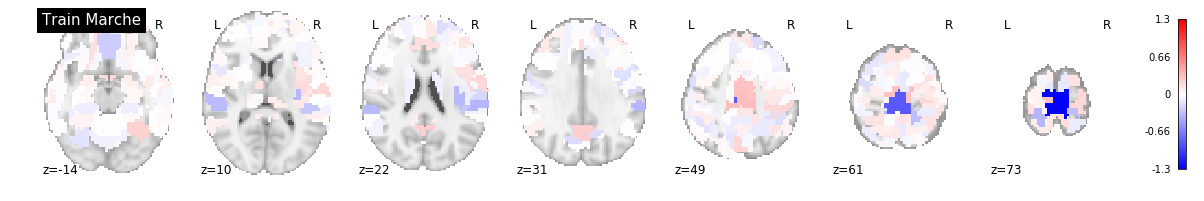

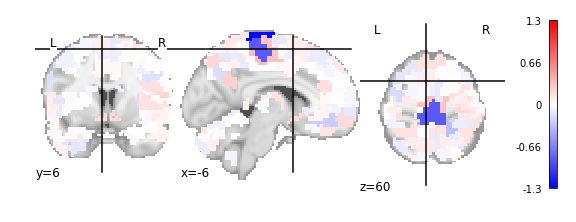

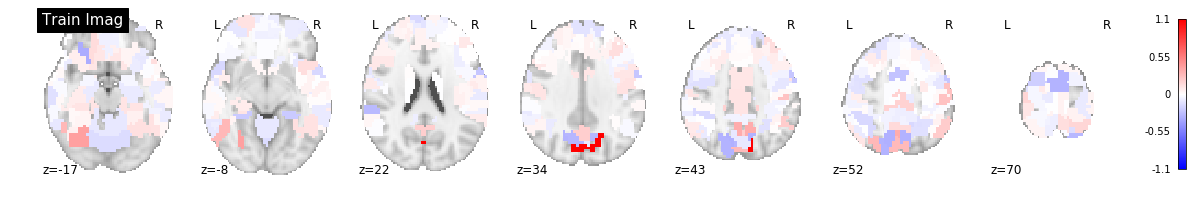

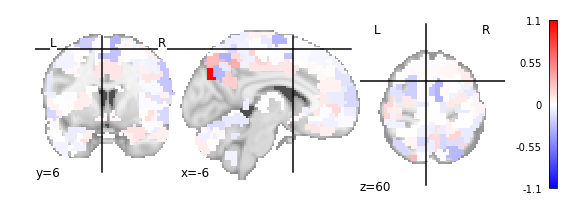

In [12]:

mem = Memory('nilearn_cache')
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')['scale444']

brainmask = load_mni152_brain_mask()
masker = NiftiLabelsMasker(labels_img = basc, mask_img = brainmask, 
                           memory=mem, memory_level=1, verbose=0,
                           detrend=False, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels')
masker.fit()

weight_img_trimp = masker.inverse_transform(coef_tr_imp)
plot_stat_map(weight_img_trimp, title='Train Marche',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trimp,cmap='bwr', cut_coords=[-6, 6, 60])
weight_img_trimag = masker.inverse_transform(coef_tr_imag)
plot_stat_map(weight_img_trimag, title='Train Imag',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trimag,cmap='bwr', cut_coords=[-6, 6, 60])

Visualisation des activités des regions les plus discriminantes pour le SVM

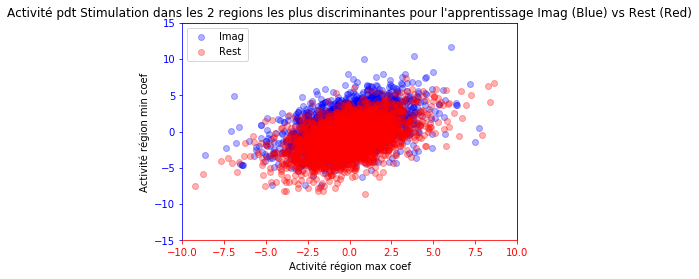

In [29]:
import matplotlib.pyplot as plt
amax_S=roi_imp_all[y_imp_all==b'imp',coef_imag.argmax()]
amax_R=roi_imp_all[y_imp_all==b'restimp',coef_imag.argmax()]
amin_S=roi_imp_all[y_imp_all==b'imp',coef_imag.argmin()]
amin_R=roi_imp_all[y_imp_all==b'restimp',coef_imag.argmin()]
fig=plt.figure()
ax=plt.subplot(1,1,1)
ax.scatter(amax_S,amin_S,c='b',alpha=0.3,label='Imag')
ax.scatter(amax_R,amin_R,c='r',alpha=0.3,label='Rest')
plt.xlabel('Activité région max coef')
plt.ylabel('Activité région min coef')
ax.spines['bottom'].set_color('r')
ax.spines['left'].set_color('b')
ax.tick_params(axis='x', colors='r')
ax.tick_params(axis='y', colors='b')
plt.legend()
plt.xlim(-10,10)
plt.ylim(-15,15)
plt.title("Activité pdt Stimulation dans les 2 regions les plus discriminantes pour l'apprentissage Imag (Blue) vs Rest (Red)")

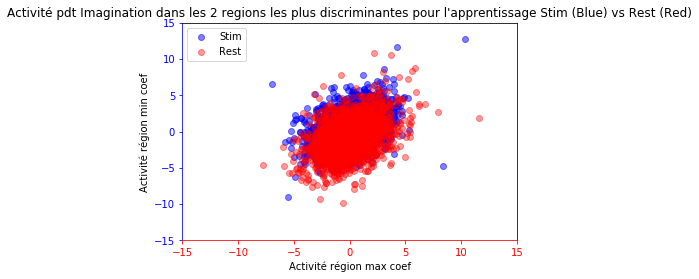

In [30]:
import matplotlib.pyplot as plt
amax_S=roi_imag_all[y_imp_all==b'imp',coef_imp.argmax()]
amax_R=roi_imag_all[y_imp_all==b'restimp',coef_imp.argmax()]
amin_S=roi_imag_all[y_imp_all==b'imp',coef_imp.argmin()]
amin_R=roi_imag_all[y_imp_all==b'restimp',coef_imp.argmin()]

fig=plt.figure()
ax=plt.subplot(1,1,1)
plt.scatter(amax_S,amin_S,c='b',alpha=0.5,label='Stim')
plt.scatter(amax_R,amin_R,c='r',alpha=0.4,label='Rest')
plt.xlabel('Activité région max coef')
plt.ylabel('Activité région min coef')
ax.spines['bottom'].set_color('r')
ax.spines['left'].set_color('b')
ax.tick_params(axis='x', colors='r')
ax.tick_params(axis='y', colors='b')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.legend()
plt.title("Activité pdt Imagination dans les 2 regions les plus discriminantes pour l'apprentissage Stim (Blue) vs Rest (Red)")

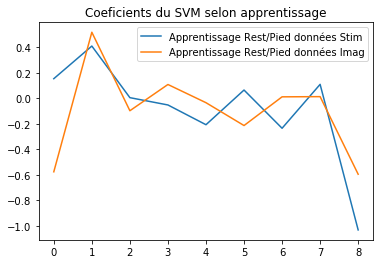

In [31]:
plt.plot(coef_imp.T,label='Apprentissage Rest/Pied données Stim')
plt.plot(coef_imag.T,label='Apprentissage Rest/Pied données Imag')
plt.title('Coeficients du SVM selon apprentissage')
plt.legend()

Test statistique

In [33]:
### Permutation (random par sujet)
nb_p=1000
null_result_tr_imag=np.zeros(nb_p)
null_result_tr_imp=np.zeros(nb_p)
nb_s=len(names)
for i in range(nb_p):
    y_train_random=np.zeros((0,1),dtype='S12')
    for suj in range(nb_s):
        suj_train_random=np.random.permutation(y_imp)
        y_train_random=np.append(y_train_random,suj_train_random)

        
    pipeline.fit(roi_imp_all, y_train_random)
    prediction = pipeline.predict(roi_imag_all) 
    null_result_tr_imp[i]=accuracy_score(prediction,y_imp_all)
    
    pipeline.fit(roi_imag_all, y_train_random)
    prediction = pipeline.predict(roi_imp_all) 
    null_result_tr_imag[i]=accuracy_score(prediction,y_imp_all)

sign_tr_imag=(null_result_tr_imag>=result_tr_imag_all).sum()/nb_p
sign_tr_imp=(null_result_tr_imp>=result_tr_imp_all).sum()/nb_p
print('tr_imag',sign_tr_imag,'tr_imp',sign_tr_imp)

ValueError: Found input variables with inconsistent numbers of samples: [342, 6726]

# Apprentissage sur tous - test indiv

In [21]:
result_tr_imp=[]
result_tr_imag=[]
nb_s=len(names)
nb_p=1000
null_result_tr_imag=np.zeros((nb_s,nb_p))
null_result_tr_imp=np.zeros((nb_s,nb_p))
for i,n in enumerate(sorted(names)):
    roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    roi=roi[:,motor_label-1]
    roi_imp=roi[mask_imp]
    roi_imag=roi[mask_imag]
    pipeline.fit(roi_imp_all,y_imp_all)    
    prediction = pipeline.predict(roi_imag)  
    result_tr_imp.append(accuracy_score(prediction,y_imp))
    pipeline.fit(roi_imag_all,y_imag_all)
    prediction = pipeline.predict(roi_imp)  
    result_tr_imag.append(accuracy_score(prediction,y_imag))
    
for z in range(nb_p):
    y_train_random=np.zeros((0,1),dtype='S12')
    for suj in range(nb_s):
        suj_train_random=np.random.permutation(y_imp)
        y_train_random=np.append(y_train_random,suj_train_random) 
    pipeline.fit(roi_imp_all, y_train_random)        
    for i,n in enumerate(sorted(names)):
        roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
        roi=np.load(roi_name)['roi']
        roi=roi[:,motor_label-1]
        roi_imp=roi[mask_imp]
        roi_imag=roi[mask_imag]        
        prediction = pipeline.predict(roi_imag) 
        null_result_tr_imp[i,z]=accuracy_score(prediction,y_imp)
        
    pipeline.fit(roi_imag_all, y_train_random)    
    for i,n in enumerate(sorted(names)):
        roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
        roi=np.load(roi_name)['roi']
        roi=roi[:,motor_label-1]
        roi_imp=roi[mask_imp]
        roi_imag=roi[mask_imag]   
        prediction = pipeline.predict(roi_imp) 
        null_result_tr_imag[i,z]=accuracy_score(prediction,y_imp)

for i,n in enumerate(sorted(names)):        
    sign_tr_imag=(null_result_tr_imag[i,:]>=result_tr_imag[i]).sum()/nb_p
    sign_tr_imp=(null_result_tr_imp[i,:]>=result_tr_imp[i]).sum()/nb_p
    print(n,'tr_imp',result_tr_imp[i],'tr_imp',sign_tr_imp,'tr_imag',result_tr_imag[i],'tr_imag',sign_tr_imag)






af tr_imp 0.640350877193 tr_imp 0.158 tr_imag 0.5 tr_imag 0.516
an tr_imp 0.631578947368 tr_imp 0.023 tr_imag 0.543859649123 tr_imag 0.281
ap tr_imp 0.719298245614 tr_imp 0.007 tr_imag 0.622807017544 tr_imag 0.072
as tr_imp 0.5 tr_imp 0.517 tr_imag 0.622807017544 tr_imag 0.103
ba tr_imp 0.561403508772 tr_imp 0.266 tr_imag 0.447368421053 tr_imag 0.817
be tr_imp 0.587719298246 tr_imp 0.217 tr_imag 0.605263157895 tr_imag 0.159
bh tr_imp 0.526315789474 tr_imp 0.368 tr_imag 0.412280701754 tr_imag 0.94
bi tr_imp 0.684210526316 tr_imp 0.113 tr_imag 0.508771929825 tr_imag 0.494
bm tr_imp 0.719298245614 tr_imp 0.02 tr_imag 0.59649122807 tr_imag 0.188
boh tr_imp 0.517543859649 tr_imp 0.457 tr_imag 0.640350877193 tr_imag 0.055
br tr_imp 0.622807017544 tr_imp 0.242 tr_imag 0.710526315789 tr_imag 0.038
cas tr_imp 0.815789473684 tr_imp 0.001 tr_imag 0.763157894737 tr_imag 0.001
cb tr_imp 0.657894736842 tr_imp 0.075 tr_imag 0.587719298246 tr_imag 0.136
cc tr_imp 0.578947368421 tr_imp 0.086 tr_imag 0.

In [22]:

from sklearn.dummy import DummyClassifier
nb_p=1000
dumsco=np.zeros(nb_p)
dummy=DummyClassifier()
dummy.fit(roi_imp_all,y_imp_all) 
for n in range(nb_p):
    dumsco[n]=dummy.score(roi_imag_all,y_imp_all)

print(dumsco.mean(),dumsco.max(),dumsco.min())

0.500166666667 0.519179304193 0.480969372584


In [23]:
from scipy.stats import binom_test
result_tr_imp=[]
result_tr_imag=[]
stat_trimp=[]
stat_trimag=[]
for i,n in enumerate(sorted(names)):
    roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    roi=roi[:,motor_label-1]
    roi_imp=roi[mask_imp]
    roi_imag=roi[mask_imag]
    pipeline.fit(roi_imp_all,y_imp_all)    
    prediction = pipeline.predict(roi_imag) 
    stat_trimp.append(binom_test((prediction==y_imp).sum(),n=len(y_imp),p=0.5))
    result_tr_imp.append(accuracy_score(prediction,y_imp))
    pipeline.fit(roi_imag_all,y_imag_all)
    prediction = pipeline.predict(roi_imp)  
    result_tr_imag.append(accuracy_score(prediction,y_imag))
    stat_trimag.append(binom_test((prediction==y_imag).sum(),n=len(y_imag),p=0.5))
    print(n,'tr_imp',result_tr_imp[i],stat_trimp[i],'tr_imag',result_tr_imag[i],stat_trimag[i])
       
    

af tr_imp 0.640350877193 0.00350468378461 tr_imag 0.5 1.0
an tr_imp 0.631578947368 0.0063516239199 tr_imag 0.543859649123 0.399373186881
ap tr_imp 0.719298245614 3.13852461616e-06 tr_imag 0.622807017544 0.0111185934488
as tr_imp 0.5 1.0 tr_imag 0.622807017544 0.0111185934488
ba tr_imp 0.561403508772 0.223230362456 tr_imag 0.447368421053 0.30287755263
be tr_imp 0.587719298246 0.0746925300798 tr_imag 0.605263157895 0.0307763238544
bh tr_imp 0.526315789474 0.639769368643 tr_imag 0.412280701754 0.0746925300798
bi tr_imp 0.684210526316 0.000104236705616 tr_imag 0.508771929825 0.925434961257
bm tr_imp 0.719298245614 3.13852461616e-06 tr_imag 0.59649122807 0.0487246863987
boh tr_imp 0.517543859649 0.778876092003 tr_imag 0.640350877193 0.00350468378461
br tr_imp 0.622807017544 0.0111185934488 tr_imag 0.710526315789 8.0043218008e-06
cas tr_imp 0.815789473684 5.31239893414e-12 tr_imag 0.763157894737 1.52616514638e-08
cb tr_imp 0.657894736842 0.000959196769898 tr_imag 0.587719298246 0.07469253007

In [24]:
len(prediction==y_imp)


114